# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
print('Размер выборки:',data.shape[0])

Размер выборки: 7591


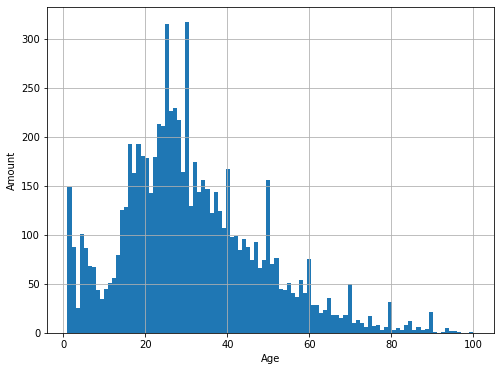

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(data['real_age'], bins=100)
ax.grid()
ax.set_xlabel('Age')
ax.set_ylabel('Amount');

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

In [7]:
datagen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(datagen_flow)

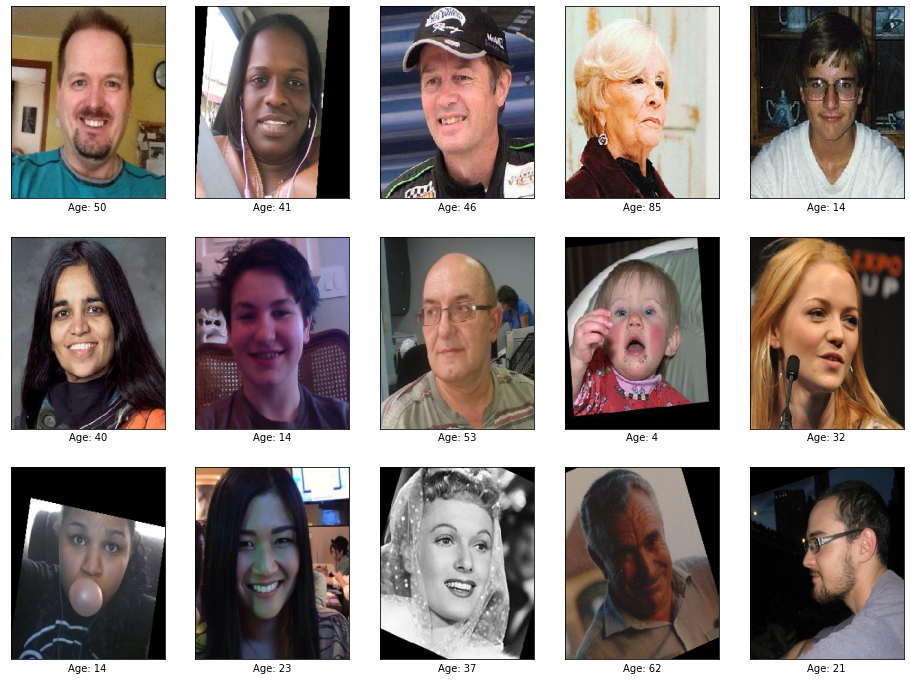

In [9]:
_, axs = plt.subplots(3,5, figsize=(16,12))
for i in range(3):
    for j in range(5):
        ax = axs[i,j]
        ax.imshow(features[i*5+j],  aspect='auto')
        ax.set_xlabel('Age: ' + str(target[i*5+j]))
        ax.set_xticks([])
        ax.set_yticks([])

<div class="alert alert-block alert-info">
<b>Комментарий:</b> На графике распределения возраста мы видем, что преимущественно мы имеем фотографии с возрастом от 15 до 30 лет, количество фотографий пожилых людей маленькое, особенно тех, чей возраст приближается к 100 годам. По первым 15 фотографиям мы видим, что в выборке присутсвуют фото, которое уже прошло некоторую обработку: сдвиги изображения и повороты. Кроме того, одно фото черно-белое, может оно такое не единственное. Эти факторы будут сказываться на точности предсказания различных возрастов и подаваемых фотографий. 
</div>

## Обучение модели

<div class="alert alert-block alert-info">
<b>Комментарий:</b> Код для обучение сверточной сети с архитекрурой ResNet50
</div>

```python

import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    train_datagen = ImageDataGenerator(validation_split = 0.25, 
                                       rescale=1./255,
                                       horizontal_flip = True,
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + '/labels.csv'),
                                                           directory=path + '/final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=32,
                                                           subset='training',
                                                           class_mode='raw',
                                                           seed=12345)
    return train_datagen_flow

def load_test(path):
    validation_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    val_datagen_flow = validation_datagen.flow_from_dataframe(dataframe=pd.read_csv(path + '/labels.csv'),
                                                              directory=path + '/final_files/',
                                                              x_col='file_name',
                                                              y_col='real_age',
                                                              target_size=(224, 224),
                                                              batch_size=32,
                                                              subset='validation',
                                                              class_mode='raw',
                                                              seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False) 

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 112s - loss: 246.9080 - mae: 11.1709 - val_loss: 467.1426 - val_mae: 16.5177
Epoch 2/10
178/178 - 88s - loss: 93.9446 - mae: 7.3532 - val_loss: 586.6269 - val_mae: 19.1921
Epoch 3/10
178/178 - 93s - loss: 71.3971 - mae: 6.4019 - val_loss: 275.5760 - val_mae: 12.5008
Epoch 4/10
178/178 - 98s - loss: 55.5409 - mae: 5.7037 - val_loss: 103.2787 - val_mae: 7.5999
Epoch 5/10
178/178 - 97s - loss: 51.2031 - mae: 5.4778 - val_loss: 102.9450 - val_mae: 7.6810
Epoch 6/10
178/178 - 99s - loss: 43.2463 - mae: 5.0474 - val_loss: 107.0048 - val_mae: 7.9318
Epoch 7/10
178/178 - 96s - loss: 37.0027 - mae: 4.6777 - val_loss: 75.2162 - val_mae: 6.5484
Epoch 8/10
178/178 - 91s - loss: 33.8931 - mae: 4.4891 - val_loss: 85.5685 - val_mae: 6.7874
Epoch 9/10
178/178 - 92s - loss: 28.6995 - mae: 4.1108 - val_loss: 65.8428 - val_mae: 6.3014
Epoch 10/10
178/178 - 92s - loss: 25.8101 - mae: 3.9302 - val_loss: 77.3907 - val_mae: 6.4916

60/60 - 10s - loss: 77.3907 - mae: 6.4916
Test MAE: 6.4916

```

## Анализ обученной модели

**Вывод:** Удалось получить среднюю абсолютную ошибку 7.5 лет, лучшим результатом было 6, однако есть некоторый элемент случайности в обучении. Кроме того, пробовалась различные вариант аугментации, однако повороты и сдвиги изображения не давали лучших результатов, чем представленный вариант. На обучение модели ушло меньше 10 минут, что, по моему мнению, очень хороший результат. 
